In [1]:
# import some helpful python packages 
import numpy as np
import math
from kapteyn import kmpfit

from astropy.table import Table, join
from astropy.io import fits
from astropy.convolution import convolve, Gaussian1DKernel

import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.image as img
from matplotlib.pyplot import rc

%matplotlib inline

# DESI targeting masks - 
from desitarget.sv1 import sv1_targetmask    # For SV1
from desitarget.sv2 import sv2_targetmask    # For SV2
from desitarget.sv3 import sv3_targetmask    # For SV3

## DataLab related modules
from sparcl.client import SparclClient
from dl import queryClient as qc
import time

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import json
import pickle

# plots default setup
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (14,8)

client = SparclClient()
ELG = fits.open("../dataset/ELG.fits", memmap = True)
ELG = ELG[1].data

In [8]:
def selection_OII(path = None, ELG = ELG, redshift_range = [0.1, 0.4], OII_SNR = 5, OIII_SNR = 5, HALPHA_SNR = 5):
    
    def BOX_SNR(dataset, feature):
        signal = dataset[str(feature) + "_BOXFLUX"]
        noise = dataset[str(feature) + "_BOXFLUX_IVAR"]
        preSNR = signal / noise ** (-1 / 2)
        return np.nan_to_num(preSNR)

    mask_redshift_low = ELG["Z_1"] < redshift_range[1]
    mask_redshift_high = ELG["Z_1"] > redshift_range[0]
    selection = ELG[mask_redshift_low & mask_redshift_high] 

    mask_box_OII = BOX_SNR(selection, "OII_3726") > OII_SNR
    selection = selection[mask_box_OII]
    
    mask_box_OIII = BOX_SNR(selection, "OIII_5007") < OIII_SNR
    selection = selection[mask_box_OIII]
    
    mask_box_HALPHA = BOX_SNR(selection, "HALPHA") < HALPHA_SNR
    selection = selection[mask_box_HALPHA]

    specid_list = [int(i) for i in selection["TARGETID"]]
    redshift = [i for i in selection["Z_1"]]
    pair = {i: j for i, j in zip(specid_list, redshift)}
    
    print(len(specid_list))
    print(len(set(specid_list)))
    
    inc = ['sparcl_id', 'specid' , 'redshift', 'flux', 'wavelength', 'model', 'ivar', 'specprimary']
    results = client.retrieve_by_specid(specid_list = specid_list, include = inc, dataset_list = ['DESI-EDR'], limit = 24000)
    results = results.reorder(specid_list)
    records = results.records
    spectra = []
    
    for i in records:
        try:
            if i["specprimary"] == True:
                i["redshift"] =  pair[int(i["specid"])]
                spectra.append(i)
            else:
                pass
        except:
            pass
    if path != None:
        with open(str(path) + "spectra.pkl", "wb") as fh:
            pickle.dump(spectra, fh)
        with open(str(path) + "results.pkl", "wb") as fh:
            pickle.dump(results, fh)
        with open(str(path) + "records.pkl", "wb") as fh:
            pickle.dump(records, fh)
    else:
        pass
    
    return spectra, results, records

In [3]:
def plot_spec(spectra, end, init = 0, path = None, Lya = True):
    for i in range(init, end):
        record = spectra[i]
    
        flux = record.flux
        wavelength = record.wavelength
        model = record.model
        redshift = record.redshift
        ivar = record.ivar
        targetid = record.specid
        sparcl_id = record.sparcl_id

        w = wavelength
        f = flux
        m = model
        iv = np.sqrt(ivar) ** -1

        if redshift > 0.4:
            continue
        if np.max(f) == np.inf:
            f[np.where(f == np.inf)] = np.median(f)
        elif np.max(m) == np.inf:
            m[np.where(m == np.inf)] = np.median(fm)
        elif np.max(iv) == np.inf:
            iv[np.where(iv == np.inf)] = np.median(iv)
        
        if Lya == True:
            min = 3726.032 * (redshift + 1) - 25
            max = 3726.032 * (redshift + 1) + 25
            mask_min = wavelength > min
            mask_max = wavelength < max
            w = wavelength[mask_min & mask_max]
            f = flux[mask_min & mask_max]
            m = model[mask_min & mask_max]
            iv = np.sqrt(ivar[mask_min & mask_max]) ** -1
            
            if redshift > 0.4:
                continue
            if np.max(f) == np.inf:
                f[np.where(f == np.inf)] = np.median(f)
            elif np.max(m) == np.inf:
                m[np.where(m == np.inf)] = np.median(fm)
            elif np.max(iv) == np.inf:
                iv[np.where(iv == np.inf)] = np.median(iv)
        else:
            pass

        plt.close()
        plt.title(f"ID = {sparcl_id}\n"
                  f"target ID = {targetid}\n"
                  f"Redshift = {redshift}\n", loc='left')
        plt.xlabel('$\lambda\ [\AA]$')
        plt.ylabel('$f_{\lambda}$ $(10^{-17}$ $erg$ $s^{-1}$ $cm^{-2}$ $\AA^{-1})$')
        
        # Plot unsmoothed spectrum in grey
        plt.plot(w, f, color = 'k', alpha = 0.2, label='Unsmoothed spectrum')
        
        # Overplot spectrum smoothed using a 1-D Gaussian Kernel in black
        plt.plot(w, convolve(f, Gaussian1DKernel(2)), color='k', label='Smoothed spectrum')

        # Overplot the model spectrum in red
        plt.plot(w, m, color = 'r', label = 'Model spectrum')
    
        plt.plot(w, iv, color = 'orange', alpha = 0.5, label = 'noise')
    
        plt.legend()
        plt.savefig(str(path) + f"/spectrum_{targetid}_OII.png", bbox_inches='tight')

In [4]:
def fitting_Lya(spectra, end, result_path = None, spectra_path = None, init = 0, file_name = "OII_fitting"):
    
    LAE = []
    NLAE_high = []
    NLAE_medium = []
    NLAE_low = []
    
    if os.path.isdir(str(result_path)):
        pass
    else:
        os.mkdir(str(result_path))

    if os.path.isdir(str(spectra_path)):
        pass
    else:
        os.mkdir(str(spectra_path))

    TARGETID = []
    CHI2_MIN = []
    REDUCED_CHI2 = []
    PARAMS = []
    ASYMPTOTIC_ERROR = []
    STANDARD_ERROR = []
    WRONG_Z = []
    TRUE_Z = []
    LYA_FLUX = []
    LYA_EW = []
    n = 0
    
    for i in range(init, end):
        n += 1
        print(f"\rProcess: {str(n / end * 100)} %", end = "")
        record = spectra[i]
    
        flux = record.flux
        wavelength = record.wavelength
        model = record.model
        redshift = record.redshift
        ivar = record.ivar
        targetid = record.specid
        sparcl_id = record.sparcl_id
    
        min = 3726.032 * (redshift + 1) - 25
        max = 3726.032 * (redshift + 1) + 30
        mask_min = wavelength > min
        mask_max = wavelength < max
        w = wavelength[mask_min & mask_max]
        f = flux[mask_min & mask_max]
        m = model[mask_min & mask_max]
        iv = np.sqrt(ivar[mask_min & mask_max]) ** -1
        
        if redshift > 0.4:
            continue
        if np.max(f) == np.inf:
            f[np.where(f == np.inf)] = np.median(f)
        elif np.max(m) == np.inf:
            m[np.where(m == np.inf)] = np.median(fm)
        elif np.max(iv) == np.inf:
            iv[np.where(iv == np.inf)] = np.median(iv)

        def my_model(p, x):
            A, mu, sigma, zerolev = p
            return( A * np.exp(-(x-mu)*(x-mu)/(2.0*sigma*sigma)) + zerolev )
            
        def my_residuals(p, data):
            A, mu, sigma, zerolev = p
            x, y, err = data
            return (y - my_model(p,x)) / err

        fittings = list()
        for j in range(math.ceil(3726.032 * (redshift + 1)) - 10, math.floor(3726.032 * (redshift + 1)) + 15):

            fitobj = kmpfit.Fitter(residuals = my_residuals, data = (w, f, iv), parinfo = [{"limits": [0, 100000000]}, {"limits": [3726.032 * (redshift + 1) - 10, 3726.032 * (redshift + 1) + 15]}, {"limits": [0, 10000000]}, None])
            p0 = [np.amax(f), j, 2.5, 0.1]
            
            fitobj.fit(params0 = p0)

            chi2_min = fitobj.chi2_min
            reduced_chi2 = fitobj.rchi2_min
            params = fitobj.params
            asymptotic_error = fitobj.xerror
            standard_errors = fitobj.stderr
            
            wrong_z = redshift
            true_z = fitobj.params[1] / 1215.67 - 1
            
            area = fitobj.params[2] * fitobj.params[0] * np.sqrt(2 * math.pi)
            EW = area / (fitobj.params[3] * (fitobj.params[1] / 1215.67))

            fittings.append({"targetid": targetid, "chi2_min": chi2_min, "reduced_chi2": reduced_chi2, "params": params, "asymptotic_error": list(asymptotic_error), "standard_errors": list(standard_errors),"wrong_z": wrong_z, "true_z": true_z, "EW": EW, "area": area})
            fittings.sort(key = lambda x: (x["reduced_chi2"] - 1) ** 2)

        TARGETID.append(fittings[0]['targetid'])
        CHI2_MIN.append(fittings[0]['chi2_min'])
        REDUCED_CHI2.append(fittings[0]['reduced_chi2'])
        PARAMS.append(fittings[0]['params'])
        ASYMPTOTIC_ERROR.append(fittings[0]['asymptotic_error'])
        STANDARD_ERROR.append(fittings[0]['standard_errors'])
        WRONG_Z.append(fittings[0]['wrong_z'])
        TRUE_Z.append(fittings[0]['true_z'])
        LYA_FLUX.append(fittings[0]['area'])
        LYA_EW.append(fittings[0]['EW'])
        
        if spectra_path != None:
            plt.close()
            rc('font', size = 9)
            rc('legend', fontsize = 8)
            
            plt.title(f"Target ID = {fittings[0]['targetid']}\n"
                      f"chi^2 min = {fittings[0]['chi2_min']}\n"
                      f"Reduced Chi^2 = {fittings[0]['reduced_chi2']}\n"
                      f"Redshift = {fittings[0]['true_z']}\n"
                      f"Params = {fittings[0]['params']}\n"
                      f"Flux = {fittings[0]['area']}\n"
                      f"Rest Frame EW = {fittings[0]['EW']}\n"
                      f"Standard errors = {fittings[0]['standard_errors']}\n"
                      f"Asymptotic error = {fittings[0]['asymptotic_error']}", loc = 'left')
            
            plt.xlabel('$\lambda\ [\AA]$')
            plt.ylabel('$f_{\lambda}$ $(10^{-17}$ $erg$ $s^{-1}$ $cm^{-2}$ $\AA^{-1})$')
            plt.plot(w, f, color='k', alpha = 0.4, label = 'Unsmoothed spectrum')
            plt.plot(w, iv, color='g', alpha = 0.4, label = 'noise')
            plt.plot(w, my_model(fittings[0]['params'], w), 'b', label = "Fit with kmpfit")
            plt.legend()
            plt.savefig(str(spectra_path) + f"{targetid}_OII.png", bbox_inches ='tight')
        
    Lya_emission = []
    for i in (TARGETID, CHI2_MIN, REDUCED_CHI2, PARAMS, ASYMPTOTIC_ERROR, STANDARD_ERROR, WRONG_Z, TRUE_Z, LYA_FLUX, LYA_EW):
        Lya_emission.append(i)

    if result_path != None:
        t = Table(Lya_emission, names = ("TARGETID", "CHI2_MIN", "REDUCED_CHI2", "PARAMS", "ASYMPTOTIC_ERROR", "STANDARD_ERROR", "WRONG_Z", "TRUE_Z", "LYA_FLUX", "LYA_EW"))
        t.write(str(result_path) + str(file_name) + ".fits", format = "fits")
    else:
        pass

In [9]:
spectra, results, records = selection_OII(path = "../final_dataset/")

/tmp/ipykernel_9527/4253918779.py:6: RuntimeWarning: divide by zero encountered in power
  preSNR = signal / noise ** (-1 / 2)


386
379


Process: 0.53475935828877 %%

/tmp/ipykernel_9527/1647027381.py:63: RuntimeWarning: divide by zero encountered in true_divide
  return( A * np.exp(-(x-mu)*(x-mu)/(2.0*sigma*sigma)) + zerolev )


Process: 44.11764705882353 %%

/tmp/ipykernel_9527/1647027381.py:50: RuntimeWarning: divide by zero encountered in reciprocal
  iv = np.sqrt(ivar[mask_min & mask_max]) ** -1


Process: 100.0 %2032085562 %%

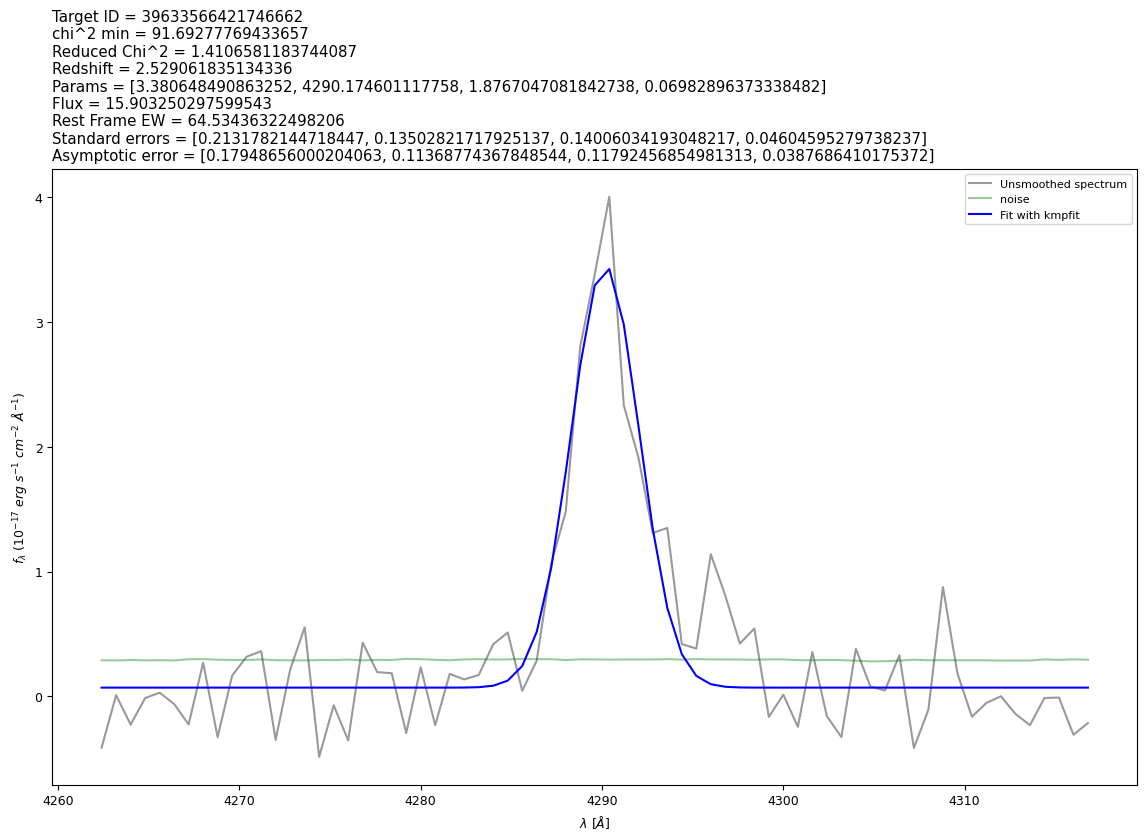

In [10]:
fitting_Lya(spectra = spectra, result_path = "../final_dataset/", spectra_path = "../final_dataset/OII_spectra/", end = len(spectra))

/tmp/ipykernel_9527/3539076298.py:16: RuntimeWarning: divide by zero encountered in reciprocal
  iv = np.sqrt(ivar) ** -1


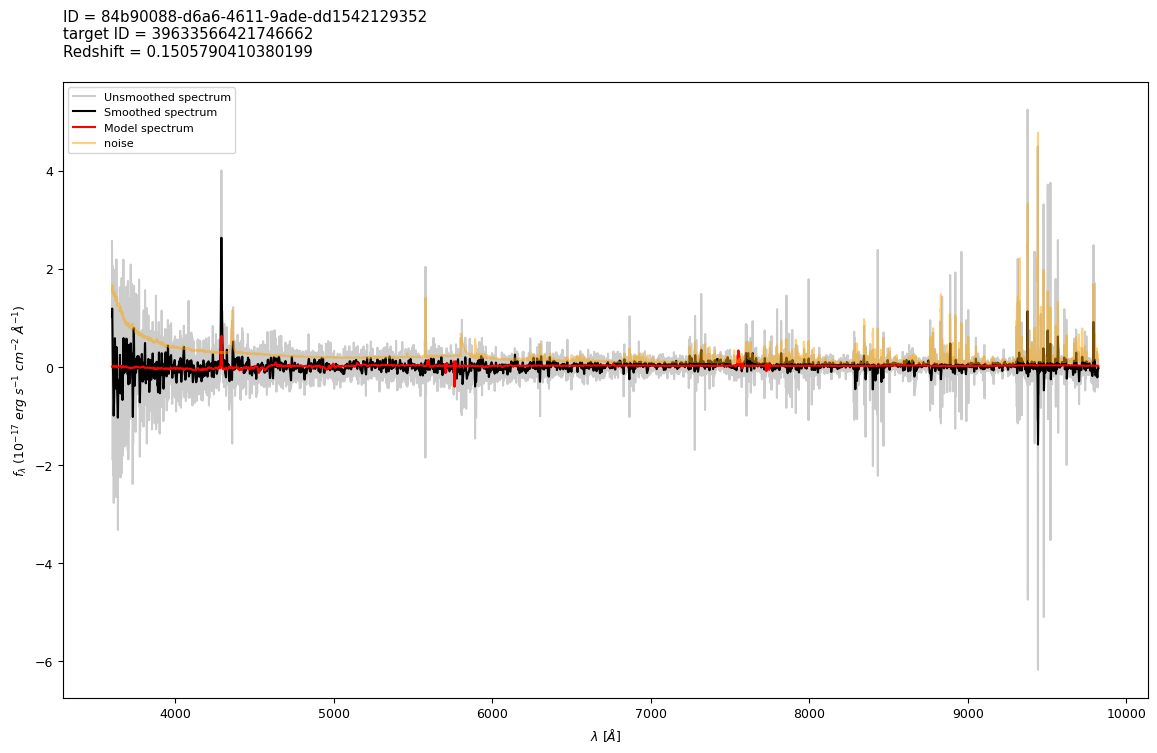

In [13]:
plot_spec(spectra = spectra, end = len(spectra), init = 0, path = "../final_dataset/OII_spectra_whole/", Lya = False)